In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this 0ㅣㅔ(by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
df_train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
df_val = df_train[40016:];
df_train = df_train[:40000]
df_test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
df_sample_submission = pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")

In [3]:
df_val

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
40016,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40017,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40018,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40019,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40020,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_test

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df_sample_submission

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27995,27996,0
27996,27997,0
27997,27998,0
27998,27999,0


In [6]:
example_digit = df_train.loc[7].drop("label").to_numpy()
example_digit = example_digit.reshape(28,28)

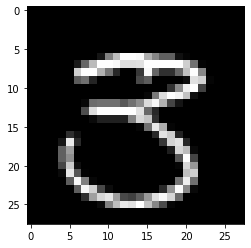

3


In [7]:
import matplotlib.pyplot as plt

plt.imshow(example_digit, cmap="gray")
plt.show()

print(df_train.loc[7]["label"])

In [8]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset) :
    def __init__(self, df_data) :
        self.x = torch.Tensor(df_data.drop("label",axis=1).values);
        self.y = torch.Tensor(df_data["label"].values);
    
    def __getitem__(self, idx) :
        return self.x[idx].reshape(1,28,28),self.y[idx];
    
    def __len__ (self) :
        return len(self.x);
    

In [9]:
bs = 16;

train_dataset = CustomDataset(df_train)
train_dataloader = DataLoader(train_dataset, batch_size = bs, shuffle=True)
val_dataset = CustomDataset(df_val)
val_dataloader = DataLoader(val_dataset, batch_size = bs, shuffle=True)

In [10]:
next(iter(train_dataloader))[0].shape

torch.Size([16, 1, 28, 28])

In [64]:
from torch import nn

class HongNet(nn.Module) :
    def __init__(self) :
        super(HongNet, self).__init__()
        self.seq_module = nn.Sequential(
            nn.Conv2d(1,10,3,stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(10,10,3,stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(10,10,3,stride = 1, padding =1 ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features = 10*13*13, out_features = 4096),
            nn.ReLU(),
            nn.Linear(in_features = 4096, out_features = 512),
            nn.ReLU(),
            nn.Linear(in_features = 512, out_features = 1),
            nn.ReLU()
        )
        
    def forward(self, x) :
        x = self.seq_module(x);
        #print("forward x value : ", x)
        x = x.reshape(bs,-1)
        #print(x.shape)
        return self.classifier(x);
    

In [81]:
model = HongNet()
print(model)

HongNet(
  (seq_module): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1690, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
    (5): ReLU()
  )
)


In [82]:
print(model.forward(next(iter(train_dataloader))[0]))

tensor([[0.6827],
        [0.0000],
        [0.8528],
        [0.8712],
        [0.0000],
        [0.0000],
        [0.1762],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.1161],
        [1.1530],
        [0.0000],
        [0.0000],
        [0.7272],
        [0.0000]], grad_fn=<ReluBackward0>)


In [83]:
loss_fn = nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr= 1e-8)

In [84]:
def train(dataloader, model, loss_fn, optimizer) :
    size = len(dataloader.dataset)
    for batch, (X, y), in enumerate(dataloader):
        pred = model.forward(X).view(16)
        #if( pred.count_nonzero() != 0) : 
        #    print(batch , " : prediction : " ,pred, "\n y : " , y);
            
        loss =loss_fn(pred, y)
        train_loss_log.append(loss.detach().item());
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if(batch%400==0) :
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
            

In [85]:
def test(dataloader, model, loss_fn) :
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    val_loss, correct =0, 0
    with torch.no_grad():
        for X, y in dataloader:
            
            pred = model.forward(X).view(16)
            ans = np.around(model.forward(X).detach().numpy().squeeze())
            #print("i predicted to ", pred," to ", ans, " and answer was ", y)
            val_loss += loss_fn(pred, y).item()
            correct+=torch.ne(torch.tensor(ans), y).sum().item()
    val_loss /= num_batches
    correct /= size
    accuracy_log.append(100*correct);
    print(f"val Error : \n Accuracy: { (100*correct) : >0.1f}% Avg loss : {val_loss :>8f}\n")
    

In [86]:
epochs= 5
train_loss_log = []
accuracy_log = []

In [87]:
for t in range(epochs) :
    print(f"Epoch {t+1}\n-------------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(val_dataloader, model, loss_fn)
    
print("Done!")

Epoch 1
-------------------------------------
loss: 21.884190 [    0/40000]
loss: 34.836853 [ 6400/40000]
loss: 22.293957 [12800/40000]
loss: 18.024822 [19200/40000]
loss: 18.238152 [25600/40000]
loss: 16.744671 [32000/40000]
loss: 7.225990 [38400/40000]
val Error : 
 Accuracy: 92.3% Avg loss : 10.686402

Epoch 2
-------------------------------------
loss: 10.022369 [    0/40000]
loss: 12.333544 [ 6400/40000]
loss: 6.755795 [12800/40000]
loss: 7.672071 [19200/40000]
loss: 10.450926 [25600/40000]
loss: 7.528756 [32000/40000]
loss: 6.496342 [38400/40000]
val Error : 
 Accuracy: 90.7% Avg loss : 8.091942

Epoch 3
-------------------------------------
loss: 3.503827 [    0/40000]
loss: 7.461465 [ 6400/40000]
loss: 5.077424 [12800/40000]
loss: 10.263672 [19200/40000]
loss: 4.736443 [25600/40000]
loss: 7.302829 [32000/40000]
loss: 6.794671 [38400/40000]
val Error : 
 Accuracy: 90.0% Avg loss : 7.629725

Epoch 4
-------------------------------------
loss: 7.242620 [    0/40000]
loss: 10.28042

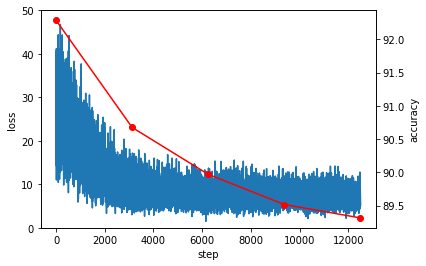

In [147]:
fig, ax = plt.subplots()
plt.xlabel('step')

ax.plot(train_loss_log)
ax.set_ylabel("loss")
ax.set_ylim([0,50])
ax2 = ax.twinx()
ax2.plot(np.linspace(1,12500,5), accuracy_log, color="red", marker="o")
ax2.set_ylabel("accuracy")
plt.savefig("naive.jpg")
plt.show()


In [100]:
np.linspace(1,5, 20)

array([1.        , 1.21052632, 1.42105263, 1.63157895, 1.84210526,
       2.05263158, 2.26315789, 2.47368421, 2.68421053, 2.89473684,
       3.10526316, 3.31578947, 3.52631579, 3.73684211, 3.94736842,
       4.15789474, 4.36842105, 4.57894737, 4.78947368, 5.        ])